## Imports

In [1]:
import math
import numpy as np
import pandas as pd

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from datetime import datetime, timedelta
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

## Input

### MM2

In [3]:
mm2_crc_df = pd.read_csv('Data/mm2_crc_merged.csv', engine='python')
mm2_crc_df['StudyID'] = mm2_crc_df['ï»¿StudyID']
mm2_crc_df = mm2_crc_df.drop('ï»¿StudyID', axis=1)

In [4]:
mm2_lca_df = pd.read_csv('Data/mm2_lca_merged.csv', engine='python')
mm2_lca_df['StudyID'] = mm2_lca_df['ï»¿StudyID']
mm2_lca_df = mm2_lca_df.drop('ï»¿StudyID', axis=1)

### MM3

In [5]:
mm3_crc_df = pd.read_csv('Data/mm3_crc_merged.csv', engine='python')
mm3_crc_df['StudyID'] = mm3_crc_df['ï»¿StudyID']
mm3_crc_df = mm3_crc_df.drop('ï»¿StudyID', axis=1)

In [6]:
mm3_lca_df = pd.read_csv('Data/mm3_lca_merged.csv', engine='python')
mm3_lca_df['StudyID'] = mm3_lca_df['ï»¿StudyID']
mm3_lca_df = mm3_lca_df.drop('ï»¿StudyID', axis=1)

## Data Prep

### MM2

In [7]:
# true EPs are ones where reviewer says it is unplanned, is really first time cancer dx, and there is a cancer signal
def is_true_EP (row):
    if (row['UnplanVal'] == 'Yes' and row['DxVal'] == 'Yes' and not pd.isnull(row['RelSig'])):
        return 1
    else:
        return 0

In [8]:
def response_num_to_text (row):
    if (row['RelRespNumerical'] == 1):
        return 'No signal requiring f/u'
    elif (row['RelRespNumerical'] == 2):
        return 'Signal not recognized'
    elif (row['RelRespNumerical'] == 3):
        return 'Signal recognized, f/u not initiated'
    elif (row['RelRespNumerical'] == 4):
        return 'Signal recognized, OP f/u'
    elif (row['RelRespNumerical'] == 5):
        return 'Signal recognized, IP f/u'
    elif (row['RelRespNumerical'] == 6):
        return 'Other'
    #else:
        #return 'ERROR'

In [9]:
def typeep_num_to_text (row):
    if (row['TypeOfEP'] == 1):
        return 'Dx within emergency event'
    elif (row['TypeOfEP'] == 2):
        return 'Cancer-related emergency -> Related subsequent encounter'
    elif (row['TypeOfEP'] == 3):
        return 'Non-cancer-related emergency -> Related subsequent encounter'
    elif (row['TypeOfEP'] == 4):
        return 'Non-cancer-related emergency -> Unrelated subsequent encounter'
    elif (row['TypeOfEP'] == 5):
        return 'Other'
    #else:
        #return 'ERROR'

In [10]:
def parse_datetime1 (row, col):
    try:
        return datetime.strptime(row[col], '%m/%d/%Y')
    except:
        return None

In [11]:
def parse_datetime2 (row, col):
    try:
        return datetime.strptime(str(row[col]), '%Y-%m-%d')
    except:
        return None

In [12]:
def is_timedelta_within_threshold (row, col_later, col_earlier, threshold):
    try:
        delta = (row[col_later] - row[col_earlier]).days
        if delta <= threshold:
            return 1
        else:
            return 0
    except:
        return -1

In [13]:
def parse_yesno_1 (row, col):
    if (row[col] == 'Yes'):
        return 1
    else:
        return 0

In [14]:
def parse_01_1 (row, col):
    if (row[col] == 1):
        return 1
    else:
        return 0

In [15]:
def check_not_null (row, col):
    if not pd.isnull(row[col]):
        return 1
    else:
        return 0

In [16]:
# make columns for each individual signal for CRC
def get_crc_sig_01 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RelSig']) and not '10' in str(row['RelSig']) and not '11' in str(row['RelSig']) and not '12' in str(row['RelSig']) and not '13' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_02 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('2' in str(x) and not '12' in str(x)):
                return 1
        return 0
    else:
        if ('2' in str(row['RelSig']) and not '12' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_03 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('3' in str(x) and not '13' in str(x)):
                return 1
        return 0
    else:
        if ('3' in str(row['RelSig']) and not '13' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_04 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('4' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('4' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_05 (row):
    if ('5' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_06 (row):
    if ('6' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_07 (row):
    if ('7' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_08 (row):
    if ('8' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_09 (row):
    if ('9' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_10 (row):
    if ('10' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_11 (row):
    if ('11' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_12 (row):
    if ('12' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_13 (row):
    if ('13' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_14 (row):
    if ('14' in str(row['RelSig'])):
        return 1
    else:
        return 0

In [17]:
# make columns for each individual signal for LCa
def get_lca_sig_01 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RelSig']) and not '10' in str(row['RelSig']) and not '11' in str(row['RelSig']) and not '12' in str(row['RelSig']) and not '13' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_lca_sig_02 (row):
    if ('2' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_03 (row):
    if ('3' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_04 (row):
    if ('4' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_05 (row):
    if ('5' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_06 (row):
    if ('6' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_07 (row):
    if ('7' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_08 (row):
    if ('8' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_09 (row):
    if ('9' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_10 (row):
    if ('10' in str(row['RelSig'])):
        return 1
    else:
        return 0

In [18]:
mm2_crc_df['TrueEP'] = mm2_crc_df.apply(lambda row: is_true_EP(row), axis=1)
mm2_lca_df['TrueEP'] = mm2_lca_df.apply(lambda row: is_true_EP(row), axis=1)

In [19]:
mm2_crc_df['ResponseText'] = mm2_crc_df.apply(lambda row: response_num_to_text(row), axis=1)
mm2_crc_df['ResponseText'] = pd.Categorical(mm2_crc_df['ResponseText'], categories=['No signal requiring f/u', 'Signal not recognized', 'Signal recognized, f/u not initiated', 'Signal recognized, OP f/u', 'Signal recognized, IP f/u', 'Other'], ordered=True)
mm2_lca_df['ResponseText'] = mm2_lca_df.apply(lambda row: response_num_to_text(row), axis=1)
mm2_lca_df['ResponseText'] = pd.Categorical(mm2_lca_df['ResponseText'], categories=['No signal requiring f/u', 'Signal not recognized', 'Signal recognized, f/u not initiated', 'Signal recognized, OP f/u', 'Signal recognized, IP f/u', 'Other'], ordered=True)

In [20]:
mm2_crc_df['TypeEPText'] = mm2_crc_df.apply(lambda row: typeep_num_to_text(row), axis=1)
mm2_crc_df['TypeEPText'] = pd.Categorical(mm2_crc_df['TypeEPText'], categories=['Dx within emergency event', 'Cancer-related emergency -> Related subsequent encounter', 'Non-cancer-related emergency -> Related subsequent encounter', 'Non-cancer-related emergency -> Unrelated subsequent encounter', 'Other'], ordered=True)
mm2_lca_df['TypeEPText'] = mm2_lca_df.apply(lambda row: typeep_num_to_text(row), axis=1)
mm2_lca_df['TypeEPText'] = pd.Categorical(mm2_lca_df['TypeEPText'], categories=['Dx within emergency event', 'Cancer-related emergency -> Related subsequent encounter', 'Non-cancer-related emergency -> Related subsequent encounter', 'Non-cancer-related emergency -> Unrelated subsequent encounter', 'Other'], ordered=True)

In [21]:
mm2_crc_df['ScreeningTestDateTime'] = mm2_crc_df.apply(lambda row: parse_datetime1(row, 'DiagnosticTestDate'), axis=1)
mm2_lca_df['ScreeningTestDateTime'] = mm2_lca_df.apply(lambda row: parse_datetime2(row, 'DiagnosticTestDate'), axis=1)
mm2_crc_df['DiagnosisDateTime'] = mm2_crc_df.apply(lambda row: parse_datetime2(row, 'DiagnosticEventDateTime'), axis=1)
mm2_lca_df['DiagnosisDateTime'] = mm2_lca_df.apply(lambda row: parse_datetime2(row, 'DiagnosticEventDateTime'), axis=1)

mm2_crc_df['ScreeningUpToDate'] = mm2_crc_df.apply(lambda row: is_timedelta_within_threshold(row, 'DiagnosisDateTime', 'ScreeningTestDateTime', 3650), axis=1)
mm2_lca_df['ScreeningUpToDate'] = mm2_lca_df.apply(lambda row: is_timedelta_within_threshold(row, 'DiagnosisDateTime', 'ScreeningTestDateTime', 3650), axis=1)

In [22]:
mm2_crc_df['RFPriorToDx'] = mm2_crc_df.apply(lambda row: parse_yesno_1(row, 'RFYesNo'), axis=1)
# lung cancer is already in 1 0 format
mm2_lca_df['RFPriorToDx'] = mm2_lca_df.apply(lambda row: parse_01_1(row, 'RFYesNo'), axis=1)

In [23]:
mm2_crc_df['HasMOD'] = mm2_crc_df.apply(lambda row: parse_yesno_1(row, 'DxMOD'), axis=1)
# lung cancer is already in 1 0 format
mm2_lca_df['HasMOD'] = mm2_lca_df.apply(lambda row: parse_01_1(row, 'DxMOD'), axis=1)

In [24]:
mm2_crc_df['DimensionPtRelated_Parsed'] = mm2_crc_df.apply(lambda row: check_not_null(row, 'DimensionPtRelated'), axis=1)
mm2_crc_df['DimensionPtProvEncounter_Parsed'] = mm2_crc_df.apply(lambda row: check_not_null(row, 'DimensionPtProvEncounter'), axis=1)
mm2_crc_df['DimensionDxTests_Parsed'] = mm2_crc_df.apply(lambda row: check_not_null(row, 'DimensionDxTests'), axis=1)
mm2_crc_df['DimensionFupTrack_Parsed'] = mm2_crc_df.apply(lambda row: check_not_null(row, 'DimensionFupTrack'), axis=1)
mm2_crc_df['DimensionReferrals_Parsed'] = mm2_crc_df.apply(lambda row: check_not_null(row, 'DimensionReferrals'), axis=1)

mm2_lca_df['DimensionPtRelated_Parsed'] = mm2_lca_df.apply(lambda row: check_not_null(row, 'DimensionPtRelated'), axis=1)
mm2_lca_df['DimensionPtProvEncounter_Parsed'] = mm2_lca_df.apply(lambda row: check_not_null(row, 'DimensionPtProvEncounter'), axis=1)
mm2_lca_df['DimensionDxTests_Parsed'] = mm2_lca_df.apply(lambda row: check_not_null(row, 'DimensionDxTests'), axis=1)
mm2_lca_df['DimensionFupTrack_Parsed'] = mm2_lca_df.apply(lambda row: check_not_null(row, 'DimensionFupTrack'), axis=1)
mm2_lca_df['DimensionReferrals_Parsed'] = mm2_lca_df.apply(lambda row: check_not_null(row, 'DimensionReferrals'), axis=1)

In [25]:
mm2_crc_df['Signal_IDA'] = mm2_crc_df.apply(lambda row: get_crc_sig_01(row), axis=1)
mm2_crc_df['Signal_Obstruction'] = mm2_crc_df.apply(lambda row: get_crc_sig_02(row), axis=1)
mm2_crc_df['Signal_BloodyStool'] = mm2_crc_df.apply(lambda row: get_crc_sig_03(row), axis=1)
mm2_crc_df['Signal_AbdMass'] = mm2_crc_df.apply(lambda row: get_crc_sig_04(row), axis=1)
mm2_crc_df['Signal_RectMass'] = mm2_crc_df.apply(lambda row: get_crc_sig_05(row), axis=1)
mm2_crc_df['Signal_StoolCaliber'] = mm2_crc_df.apply(lambda row: get_crc_sig_06(row), axis=1)
mm2_crc_df['Signal_CScope'] = mm2_crc_df.apply(lambda row: get_crc_sig_07(row), axis=1)
mm2_crc_df['Signal_FOBT'] = mm2_crc_df.apply(lambda row: get_crc_sig_08(row), axis=1)
mm2_crc_df['Signal_FlexSig'] = mm2_crc_df.apply(lambda row: get_crc_sig_09(row), axis=1)
mm2_crc_df['Signal_Enema'] = mm2_crc_df.apply(lambda row: get_crc_sig_10(row), axis=1)
mm2_crc_df['Signal_CT'] = mm2_crc_df.apply(lambda row: get_crc_sig_11(row), axis=1)
mm2_crc_df['Signal_FamHx'] = mm2_crc_df.apply(lambda row: get_crc_sig_12(row), axis=1)
mm2_crc_df['Signal_MassExam'] = mm2_crc_df.apply(lambda row: get_crc_sig_13(row), axis=1)
mm2_crc_df['Signal_Other'] = mm2_crc_df.apply(lambda row: get_crc_sig_14(row), axis=1)

In [26]:
mm2_lca_df['Signal_Cough'] = mm2_lca_df.apply(lambda row: get_lca_sig_01(row), axis=1)
mm2_lca_df['Signal_Dyspnea'] = mm2_lca_df.apply(lambda row: get_lca_sig_02(row), axis=1)
mm2_lca_df['Signal_ChestPain'] = mm2_lca_df.apply(lambda row: get_lca_sig_03(row), axis=1)
mm2_lca_df['Signal_Hemoptysis'] = mm2_lca_df.apply(lambda row: get_lca_sig_04(row), axis=1)
mm2_lca_df['Signal_LRTI'] = mm2_lca_df.apply(lambda row: get_lca_sig_05(row), axis=1)
mm2_lca_df['Signal_Imaging'] = mm2_lca_df.apply(lambda row: get_lca_sig_06(row), axis=1)
mm2_lca_df['Signal_Paraneoplastic'] = mm2_lca_df.apply(lambda row: get_lca_sig_07(row), axis=1)
mm2_lca_df['Signal_Hoarse'] = mm2_lca_df.apply(lambda row: get_lca_sig_08(row), axis=1)
mm2_lca_df['Signal_WtLoss'] = mm2_lca_df.apply(lambda row: get_lca_sig_09(row), axis=1)
mm2_lca_df['Signal_Other'] = mm2_lca_df.apply(lambda row: get_lca_sig_10(row), axis=1)

In [27]:
# mm2_crc_df[['RelSig', 'Signal_IDA', 'Signal_Obstruction', 'Signal_BloodyStool', 'Signal_AbdMass', 'Signal_RectMass', 'Signal_StoolCaliber', 'Signal_CScope', 'Signal_FOBT', 'Signal_FlexSig', 'Signal_Enema', 'Signal_CT', 'Signal_FamHx', 'Signal_MassExam', 'Signal_Other']]

In [28]:
# mm2_lca_df[['RelSig', 'Signal_Cough', 'Signal_Dyspnea', 'Signal_ChestPain', 'Signal_Hemoptysis', 'Signal_LRTI', 'Signal_Imaging', 'Signal_Paraneoplastic', 'Signal_Hoarse', 'Signal_WtLoss', 'Signal_Other']]

### MM3

In [29]:
#pending

## True EP Analysis

### CRC

In [30]:
mm2_crc_tep_stats = mm2_crc_df['TrueEP'].agg(['mean', 'std', 'count'])
    
mm2_crc_tep_stats['ci95_hi'] = (mm2_crc_tep_stats['mean'] + 1.96 * mm2_crc_tep_stats['std']/math.sqrt(mm2_crc_tep_stats['count'])) * 100
mm2_crc_tep_stats['ci95_lo'] = (mm2_crc_tep_stats['mean'] - 1.96 * mm2_crc_tep_stats['std']/math.sqrt(mm2_crc_tep_stats['count'])) * 100
mm2_crc_tep_stats['% True EP'] = mm2_crc_tep_stats['mean'] * 100

In [31]:
mm2_crc_tep_stats[['% True EP', 'ci95_hi', 'ci95_lo']]

% True EP    73.000000
ci95_hi      81.745442
ci95_lo      64.254558
Name: TrueEP, dtype: float64

### Lung Cancer

In [32]:
mm2_lca_tep_stats = mm2_lca_df['TrueEP'].agg(['mean', 'std', 'count'])
    
mm2_lca_tep_stats['ci95_hi'] = (mm2_lca_tep_stats['mean'] + 1.96 * mm2_lca_tep_stats['std']/math.sqrt(mm2_lca_tep_stats['count'])) * 100
mm2_lca_tep_stats['ci95_lo'] = (mm2_lca_tep_stats['mean'] - 1.96 * mm2_lca_tep_stats['std']/math.sqrt(mm2_lca_tep_stats['count'])) * 100
mm2_lca_tep_stats['% True EP'] = mm2_lca_tep_stats['mean'] * 100

In [33]:
mm2_lca_tep_stats[['% True EP', 'ci95_hi', 'ci95_lo']]

% True EP    80.000000
ci95_hi      87.879496
ci95_lo      72.120504
Name: TrueEP, dtype: float64

## Signals

### CRC

In [34]:
crc_sigf_df = pd.DataFrame({'Signal':['IDA', 'Obstruction', 'BloodyStool', 'AbdMass', 'RectMass', 'StoolCaliber', 'CScope', 'FOBT', 'FlexSig', 'Enema', 'CT', 'FamHx', 'MassExam', 'Other']})
crc_sigf_vals = [] 

crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_IDA'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_Obstruction'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_BloodyStool'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_AbdMass'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_RectMass'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_StoolCaliber'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_CScope'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_FOBT'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_FlexSig'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_Enema'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_CT'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_FamHx'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_MassExam'].agg('mean') * 100)
crc_sigf_vals.append(mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['Signal_Other'].agg('mean') * 100)

crc_sigf_df['Frequency'] = crc_sigf_vals
crc_sigf_df = crc_sigf_df.sort_values(by='Frequency', ascending=False)

In [35]:
crc_sigf_df

,Signal,Frequency
0,IDA,52.054795
10,CT,47.945205
2,BloodyStool,30.136986
5,StoolCaliber,17.808219
6,CScope,16.438356
1,Obstruction,8.219178
4,RectMass,6.849315
3,AbdMass,4.109589
7,FOBT,4.109589
11,FamHx,2.739726


(0.0, 100.0)

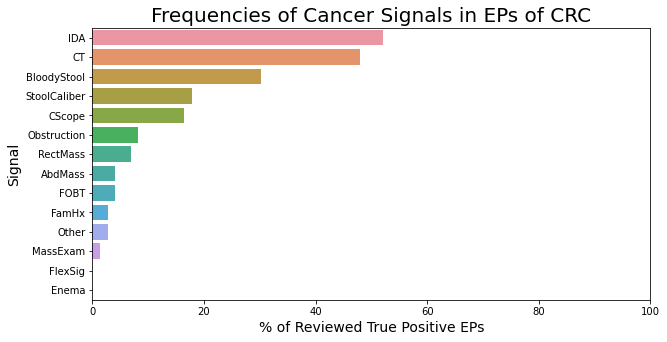

In [36]:
crc_sigf_plt = sns.barplot(data=crc_sigf_df, y='Signal', x='Frequency', orientation='horizontal')
crc_sigf_plt.axes.set_title("Frequencies of Cancer Signals in EPs of CRC", fontsize=20)
crc_sigf_plt.axes.set_ylabel ("Signal", fontsize=14)
crc_sigf_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_sigf_plt.axes.set_xlim ([0, 100])

### LCa

In [37]:
lca_sigf_df = pd.DataFrame({'Signal':['Cough', 'Dyspnea', 'ChestPain', 'Hemoptysis', 'LRTI', 'Imaging', 'Paraneoplastic', 'Hoarse', 'WtLoss', 'Other']})
lca_sigf_vals = [] 

lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Cough'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Dyspnea'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_ChestPain'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Hemoptysis'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_LRTI'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Imaging'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Paraneoplastic'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Hoarse'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_WtLoss'].agg('mean') * 100)
lca_sigf_vals.append(mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['Signal_Other'].agg('mean') * 100)

lca_sigf_df['Frequency'] = lca_sigf_vals
lca_sigf_df = lca_sigf_df.sort_values(by='Frequency', ascending=False)

(0.0, 100.0)

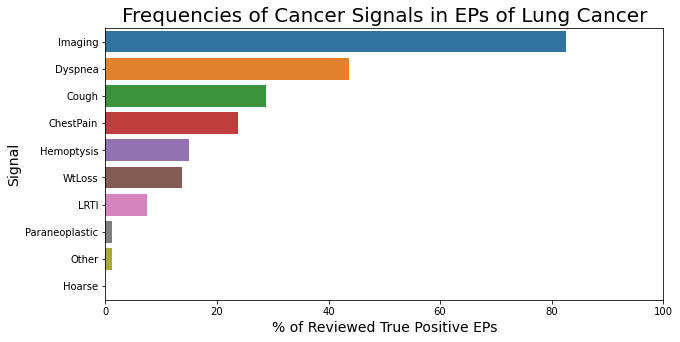

In [38]:
lca_sigf_plt = sns.barplot(data=lca_sigf_df, y='Signal', x='Frequency', orientation='horizontal')
lca_sigf_plt.axes.set_title("Frequencies of Cancer Signals in EPs of Lung Cancer", fontsize=20)
lca_sigf_plt.axes.set_ylabel ("Signal", fontsize=14)
lca_sigf_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_sigf_plt.axes.set_xlim ([0, 100])

## Clinical Response

### CRC

In [39]:
crc_resp_df = mm2_crc_df[mm2_crc_df['TrueEP'] == 1].groupby('ResponseText')['TrueEP'].agg(['count'])
crc_resp_df

,count
ResponseText,
No signal requiring f/u,0
Signal not recognized,2
"Signal recognized, f/u not initiated",0
"Signal recognized, OP f/u",13
"Signal recognized, IP f/u",55
Other,3


(0.0, 60.0)

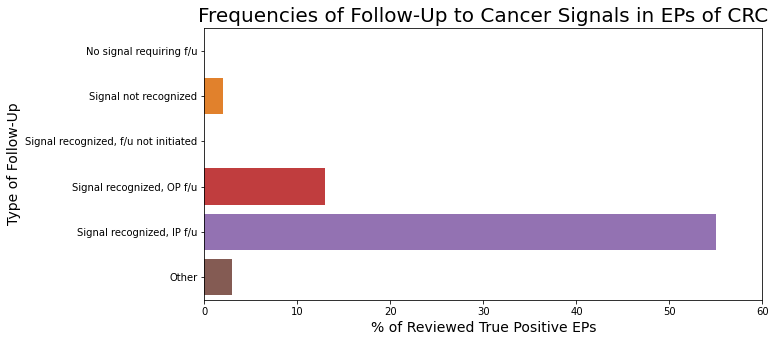

In [40]:
crc_resp_plt = sns.barplot(data=crc_resp_df, y=crc_resp_df.index, x='count', orientation='horizontal')
crc_resp_plt.axes.set_title("Frequencies of Follow-Up to Cancer Signals in EPs of CRC", fontsize=20)
crc_resp_plt.axes.set_ylabel ("Type of Follow-Up", fontsize=14)
crc_resp_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_resp_plt.axes.set_xlim ([0, 60])

### LCa

In [41]:
lca_resp_df = mm2_lca_df[mm2_lca_df['TrueEP'] == 1].groupby('ResponseText')['TrueEP'].agg(['count'])
lca_resp_df

,count
ResponseText,
No signal requiring f/u,1
Signal not recognized,2
"Signal recognized, f/u not initiated",0
"Signal recognized, OP f/u",22
"Signal recognized, IP f/u",55
Other,0


(0.0, 60.0)

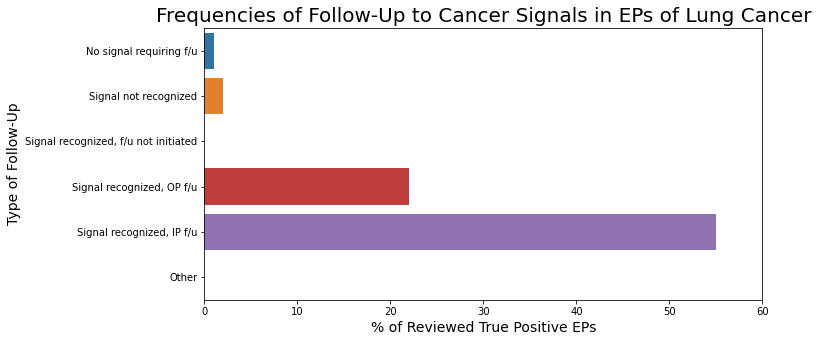

In [42]:
lca_resp_plt = sns.barplot(data=lca_resp_df, y=lca_resp_df.index, x='count', orientation='horizontal')
lca_resp_plt.axes.set_title("Frequencies of Follow-Up to Cancer Signals in EPs of Lung Cancer", fontsize=20)
lca_resp_plt.axes.set_ylabel ("Type of Follow-Up", fontsize=14)
lca_resp_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_resp_plt.axes.set_xlim ([0, 60])

## Type of EP

### CRC

In [43]:
crc_typeep_df = mm2_crc_df[mm2_crc_df['TrueEP'] == 1].groupby('TypeEPText')['TrueEP'].agg(['count'])
crc_typeep_df

,count
TypeEPText,
Dx within emergency event,51
Cancer-related emergency -> Related subsequent encounter,12
Non-cancer-related emergency -> Related subsequent encounter,8
Non-cancer-related emergency -> Unrelated subsequent encounter,2
Other,0


(0.0, 60.0)

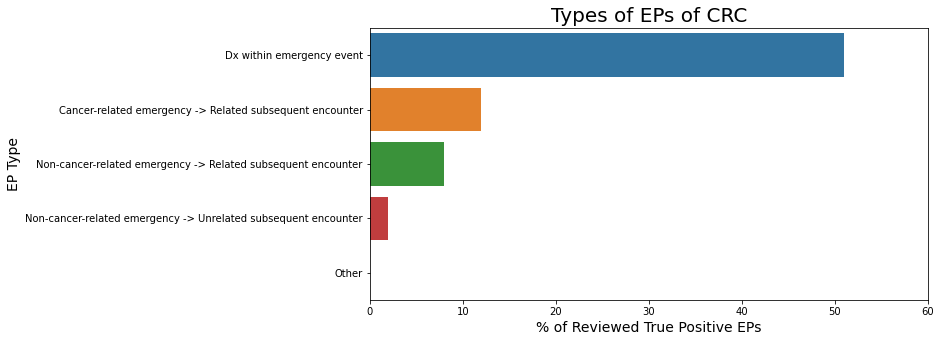

In [44]:
crc_typeep_plt = sns.barplot(data=crc_typeep_df, y=crc_typeep_df.index, x='count', orientation='horizontal')
crc_typeep_plt.axes.set_title("Types of EPs of CRC", fontsize=20)
crc_typeep_plt.axes.set_ylabel ("EP Type", fontsize=14)
crc_typeep_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_typeep_plt.axes.set_xlim ([0, 60])

### LCa

In [45]:
lca_typeep_df = mm2_lca_df[mm2_lca_df['TrueEP'] == 1].groupby('TypeEPText')['TrueEP'].agg(['count'])
lca_typeep_df

,count
TypeEPText,
Dx within emergency event,45
Cancer-related emergency -> Related subsequent encounter,20
Non-cancer-related emergency -> Related subsequent encounter,12
Non-cancer-related emergency -> Unrelated subsequent encounter,1
Other,2


(0.0, 60.0)

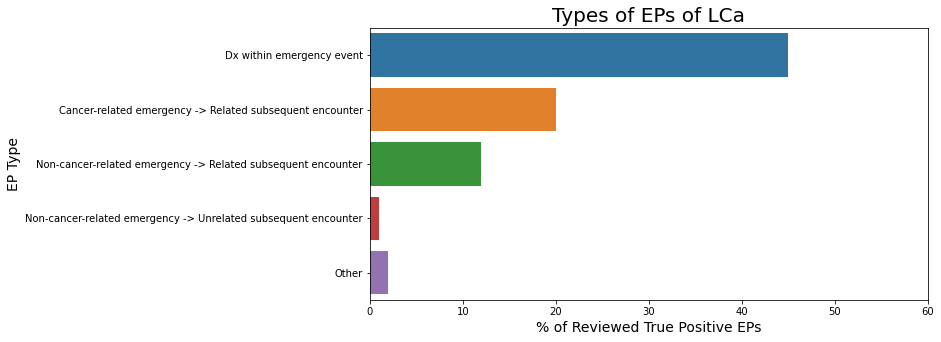

In [46]:
lca_typeep_plt = sns.barplot(data=lca_typeep_df, y=lca_typeep_df.index, x='count', orientation='horizontal')
lca_typeep_plt.axes.set_title("Types of EPs of LCa", fontsize=20)
lca_typeep_plt.axes.set_ylabel ("EP Type", fontsize=14)
lca_typeep_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_typeep_plt.axes.set_xlim ([0, 60])

## Diagnostic Testing

### CRC

In [47]:
mm2_crc_scr_stats = mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['ScreeningUpToDate'].agg(['mean'])
mm2_crc_scr_stats["% Up To Date on Screening"] = mm2_crc_scr_stats['mean'] * 100
mm2_crc_scr_stats['% Up To Date on Screening']

23.28767123287671

### LCa

In [48]:
mm2_lca_scr_stats = mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['ScreeningUpToDate'].agg(['mean'])
mm2_lca_scr_stats["% Up To Date on Screening"] = mm2_lca_scr_stats['mean'] * 100
mm2_lca_scr_stats['% Up To Date on Screening']

13.750000000000002

## Earliest Red Flag

### CRC

In [49]:
mm2_crc_rf_stats = mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['RFPriorToDx'].agg(['mean'])
mm2_crc_rf_stats["% RF prior to Dx"] = mm2_crc_rf_stats['mean'] * 100
mm2_crc_rf_stats['% RF prior to Dx']

65.75342465753424

### LCa

In [50]:
mm2_lca_rf_stats = mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['RFPriorToDx'].agg(['mean'])
mm2_lca_rf_stats["% RF prior to Dx"] = mm2_lca_rf_stats['mean'] * 100
mm2_lca_rf_stats['% RF prior to Dx']

47.5

## MOD

### CRC

In [51]:
mm2_crc_mod_stats = mm2_crc_df[mm2_crc_df['TrueEP'] == 1]['HasMOD'].agg(['mean'])
mm2_crc_mod_stats['% MODs'] = mm2_crc_mod_stats['mean'] * 100
mm2_crc_mod_stats['% MODs']

69.86301369863014

### LCa

In [52]:
mm2_lca_mod_stats = mm2_lca_df[mm2_lca_df['TrueEP'] == 1]['HasMOD'].agg(['mean'])
mm2_lca_mod_stats['% MODs'] = mm2_lca_mod_stats['mean'] * 100
mm2_lca_mod_stats['% MODs']

47.5

## MOD Dimensions

### CRC

In [53]:
crc_dim_df = pd.DataFrame({'Dimension':['Patient-Related', 'Patient-Provider Encounter', 'Diagnostic Tests', 'Follow-Up and Tracking', 'Referrals']})
crc_dim_vals = [] 

crc_dim_vals.append(mm2_crc_df[mm2_crc_df['HasMOD'] == 1]['DimensionPtRelated_Parsed'].agg('mean') * 100)
crc_dim_vals.append(mm2_crc_df[mm2_crc_df['HasMOD'] == 1]['DimensionPtProvEncounter_Parsed'].agg('mean') * 100)
crc_dim_vals.append(mm2_crc_df[mm2_crc_df['HasMOD'] == 1]['DimensionDxTests_Parsed'].agg('mean') * 100)
crc_dim_vals.append(mm2_crc_df[mm2_crc_df['HasMOD'] == 1]['DimensionFupTrack_Parsed'].agg('mean') * 100)
crc_dim_vals.append(mm2_crc_df[mm2_crc_df['HasMOD'] == 1]['DimensionReferrals_Parsed'].agg('mean') * 100)

crc_dim_df['Frequency'] = crc_dim_vals

In [54]:
crc_dim_df

,Dimension,Frequency
0,Patient-Related,57.142857
1,Patient-Provider Encounter,39.285714
2,Diagnostic Tests,23.214286
3,Follow-Up and Tracking,35.714286
4,Referrals,0.000000


(0.0, 100.0)

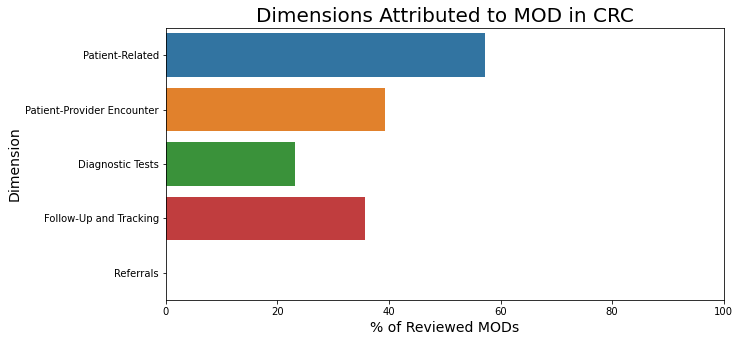

In [55]:
crc_dim_plt = sns.barplot(data=crc_dim_df, y='Dimension', x='Frequency', orientation='horizontal')
crc_dim_plt.axes.set_title("Dimensions Attributed to MOD in CRC", fontsize=20)
crc_dim_plt.axes.set_ylabel ("Dimension", fontsize=14)
crc_dim_plt.axes.set_xlabel ("% of Reviewed MODs", fontsize=14)
crc_dim_plt.axes.set_xlim ([0, 100])

### LCa

In [56]:
lca_dim_df = pd.DataFrame({'Dimension':['Patient-Related', 'Patient-Provider Encounter', 'Diagnostic Tests', 'Follow-Up and Tracking', 'Referrals']})
lca_dim_vals = [] 

lca_dim_vals.append(mm2_lca_df[mm2_lca_df['HasMOD'] == 1]['DimensionPtRelated_Parsed'].agg('mean') * 100)
lca_dim_vals.append(mm2_lca_df[mm2_lca_df['HasMOD'] == 1]['DimensionPtProvEncounter_Parsed'].agg('mean') * 100)
lca_dim_vals.append(mm2_lca_df[mm2_lca_df['HasMOD'] == 1]['DimensionDxTests_Parsed'].agg('mean') * 100)
lca_dim_vals.append(mm2_lca_df[mm2_lca_df['HasMOD'] == 1]['DimensionFupTrack_Parsed'].agg('mean') * 100)
lca_dim_vals.append(mm2_lca_df[mm2_lca_df['HasMOD'] == 1]['DimensionReferrals_Parsed'].agg('mean') * 100)

lca_dim_df['Frequency'] = lca_dim_vals

In [57]:
lca_dim_df

,Dimension,Frequency
0,Patient-Related,30.232558
1,Patient-Provider Encounter,30.232558
2,Diagnostic Tests,53.488372
3,Follow-Up and Tracking,20.930233
4,Referrals,0.000000


(0.0, 100.0)

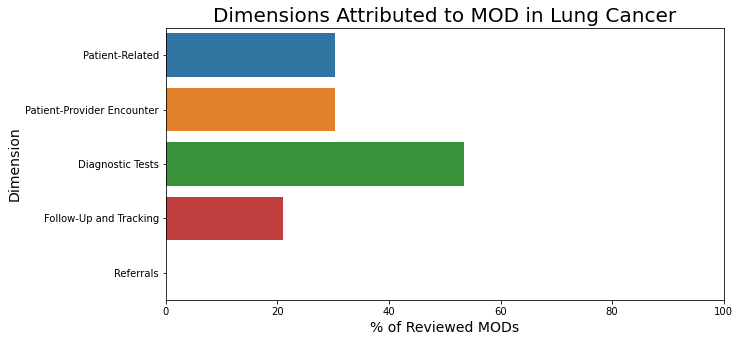

In [58]:
lca_dim_plt = sns.barplot(data=lca_dim_df, y='Dimension', x='Frequency', orientation='horizontal')
lca_dim_plt.axes.set_title("Dimensions Attributed to MOD in Lung Cancer", fontsize=20)
lca_dim_plt.axes.set_ylabel ("Dimension", fontsize=14)
lca_dim_plt.axes.set_xlabel ("% of Reviewed MODs", fontsize=14)
lca_dim_plt.axes.set_xlim ([0, 100])